<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code inspired from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [ ]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

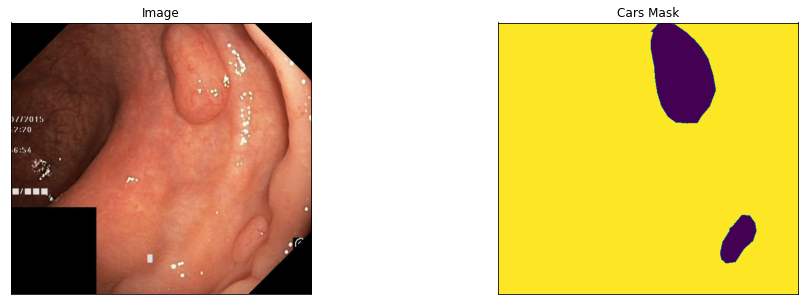

In [10]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

In [11]:
import albumentations as albu

In [12]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        #albu.Resize(576, 736)
        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [15]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['polyp', 'background']
ACTIVATION = 'sigmoid'

In [16]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

## Training

In [18]:
import torch
import torch.nn as nn
from catalyst.dl.experiments import SupervisedRunner

# experiment setup
num_epochs = 10  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
# metrics = [
#     smp.utils.metrics.IoUMetric(eps=1.),
#     smp.utils.metrics.FscoreMetric(eps=1.),
# ]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/10 * Epoch (train):   0% 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (train): 100% 100/100 [01:23<00:00,  1.19it/s, _fps=306.929, loss=0.477]
0/10 * Epoch (valid):   0% 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (valid): 100% 100/100 [00:37<00:00,  2.65it/s, _fps=73.467, loss=0.484]
[2022-11-05 18:14:15,737] 
0/10 * Epoch 0 (train): _fps=194.8145 | base/batch_time=0.4699 | base/data_time=0.3467 | base/lr=0.0010 | base/model_time=0.1231 | base/momentum=0.9000 | loss=0.5382
0/10 * Epoch 0 (valid): _fps=30.6161 | base/batch_time=0.3553 | base/data_time=0.3328 | base/lr=0.0010 | base/model_time=0.0225 | base/momentum=0.9000 | loss=0.5180


INFO:metrics:
0/10 * Epoch 0 (train): _fps=194.8145 | base/batch_time=0.4699 | base/data_time=0.3467 | base/lr=0.0010 | base/model_time=0.1231 | base/momentum=0.9000 | loss=0.5382
0/10 * Epoch 0 (valid): _fps=30.6161 | base/batch_time=0.3553 | base/data_time=0.3328 | base/lr=0.0010 | base/model_time=0.0225 | base/momentum=0.9000 | loss=0.5180


1/10 * Epoch (train): 100% 100/100 [00:46<00:00,  2.16it/s, _fps=297.674, loss=0.532]
1/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 24.85it/s, _fps=56.105, loss=0.564]
[2022-11-05 18:15:08,069] 
1/10 * Epoch 1 (train): _fps=179.8789 | base/batch_time=0.1100 | base/data_time=0.0663 | base/lr=0.0010 | base/model_time=0.0437 | base/momentum=0.9000 | loss=0.5250
1/10 * Epoch 1 (valid): _fps=39.4286 | base/batch_time=0.0299 | base/data_time=0.0110 | base/lr=0.0010 | base/model_time=0.0189 | base/momentum=0.9000 | loss=0.5215


INFO:metrics:
1/10 * Epoch 1 (train): _fps=179.8789 | base/batch_time=0.1100 | base/data_time=0.0663 | base/lr=0.0010 | base/model_time=0.0437 | base/momentum=0.9000 | loss=0.5250
1/10 * Epoch 1 (valid): _fps=39.4286 | base/batch_time=0.0299 | base/data_time=0.0110 | base/lr=0.0010 | base/model_time=0.0189 | base/momentum=0.9000 | loss=0.5215


2/10 * Epoch (train): 100% 100/100 [00:47<00:00,  2.11it/s, _fps=329.181, loss=0.521]
2/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.56it/s, _fps=65.708, loss=0.559]
[2022-11-05 18:16:02,651] 
2/10 * Epoch 2 (train): _fps=190.9279 | base/batch_time=0.1140 | base/data_time=0.0724 | base/lr=0.0010 | base/model_time=0.0414 | base/momentum=0.9000 | loss=0.5188
2/10 * Epoch 2 (valid): _fps=40.1990 | base/batch_time=0.0295 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5025


INFO:metrics:
2/10 * Epoch 2 (train): _fps=190.9279 | base/batch_time=0.1140 | base/data_time=0.0724 | base/lr=0.0010 | base/model_time=0.0414 | base/momentum=0.9000 | loss=0.5188
2/10 * Epoch 2 (valid): _fps=40.1990 | base/batch_time=0.0295 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5025


3/10 * Epoch (train): 100% 100/100 [00:47<00:00,  2.08it/s, _fps=302.925, loss=0.498]
3/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.32it/s, _fps=53.486, loss=0.424]
[2022-11-05 18:16:56,717] 
3/10 * Epoch 3 (train): _fps=192.8729 | base/batch_time=0.1193 | base/data_time=0.0839 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5175
3/10 * Epoch 3 (valid): _fps=40.5593 | base/batch_time=0.0293 | base/data_time=0.0106 | base/lr=0.0010 | base/model_time=0.0186 | base/momentum=0.9000 | loss=0.5084


INFO:metrics:
3/10 * Epoch 3 (train): _fps=192.8729 | base/batch_time=0.1193 | base/data_time=0.0839 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5175
3/10 * Epoch 3 (valid): _fps=40.5593 | base/batch_time=0.0293 | base/data_time=0.0106 | base/lr=0.0010 | base/model_time=0.0186 | base/momentum=0.9000 | loss=0.5084


4/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.01it/s, _fps=330.947, loss=0.486]
4/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 24.84it/s, _fps=64.937, loss=0.424]
[2022-11-05 18:17:53,184] 
4/10 * Epoch 4 (train): _fps=145.8468 | base/batch_time=0.1435 | base/data_time=0.0791 | base/lr=0.0010 | base/model_time=0.0642 | base/momentum=0.9000 | loss=0.5171
4/10 * Epoch 4 (valid): _fps=39.1329 | base/batch_time=0.0300 | base/data_time=0.0108 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5102


INFO:metrics:
4/10 * Epoch 4 (train): _fps=145.8468 | base/batch_time=0.1435 | base/data_time=0.0791 | base/lr=0.0010 | base/model_time=0.0642 | base/momentum=0.9000 | loss=0.5171
4/10 * Epoch 4 (valid): _fps=39.1329 | base/batch_time=0.0300 | base/data_time=0.0108 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5102


5/10 * Epoch (train): 100% 100/100 [00:47<00:00,  2.11it/s, _fps=321.513, loss=0.487]
5/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.68it/s, _fps=61.471, loss=0.439]
[2022-11-05 18:18:47,959] 
5/10 * Epoch 5 (train): _fps=190.4215 | base/batch_time=0.1159 | base/data_time=0.0806 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5098
5/10 * Epoch 5 (valid): _fps=41.4023 | base/batch_time=0.0286 | base/data_time=0.0100 | base/lr=0.0010 | base/model_time=0.0185 | base/momentum=0.9000 | loss=0.5008


INFO:metrics:
5/10 * Epoch 5 (train): _fps=190.4215 | base/batch_time=0.1159 | base/data_time=0.0806 | base/lr=0.0010 | base/model_time=0.0352 | base/momentum=0.9000 | loss=0.5098
5/10 * Epoch 5 (valid): _fps=41.4023 | base/batch_time=0.0286 | base/data_time=0.0100 | base/lr=0.0010 | base/model_time=0.0185 | base/momentum=0.9000 | loss=0.5008


6/10 * Epoch (train): 100% 100/100 [00:46<00:00,  2.13it/s, _fps=335.152, loss=0.542]
6/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.58it/s, _fps=69.134, loss=0.524]
[2022-11-05 18:19:40,993] 
6/10 * Epoch 6 (train): _fps=181.7248 | base/batch_time=0.1112 | base/data_time=0.0706 | base/lr=0.0010 | base/model_time=0.0405 | base/momentum=0.9000 | loss=0.5156
6/10 * Epoch 6 (valid): _fps=41.2574 | base/batch_time=0.0288 | base/data_time=0.0106 | base/lr=0.0010 | base/model_time=0.0181 | base/momentum=0.9000 | loss=0.5056


INFO:metrics:
6/10 * Epoch 6 (train): _fps=181.7248 | base/batch_time=0.1112 | base/data_time=0.0706 | base/lr=0.0010 | base/model_time=0.0405 | base/momentum=0.9000 | loss=0.5156
6/10 * Epoch 6 (valid): _fps=41.2574 | base/batch_time=0.0288 | base/data_time=0.0106 | base/lr=0.0010 | base/model_time=0.0181 | base/momentum=0.9000 | loss=0.5056


7/10 * Epoch (train): 100% 100/100 [00:47<00:00,  2.10it/s, _fps=335.746, loss=0.547]
7/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 24.90it/s, _fps=66.198, loss=0.546]
[2022-11-05 18:20:35,919] 
7/10 * Epoch 7 (train): _fps=192.9523 | base/batch_time=0.1159 | base/data_time=0.0803 | base/lr=0.0010 | base/model_time=0.0355 | base/momentum=0.9000 | loss=0.5135
7/10 * Epoch 7 (valid): _fps=40.5812 | base/batch_time=0.0294 | base/data_time=0.0103 | base/lr=0.0010 | base/model_time=0.0190 | base/momentum=0.9000 | loss=0.4949


INFO:metrics:
7/10 * Epoch 7 (train): _fps=192.9523 | base/batch_time=0.1159 | base/data_time=0.0803 | base/lr=0.0010 | base/model_time=0.0355 | base/momentum=0.9000 | loss=0.5135
7/10 * Epoch 7 (valid): _fps=40.5812 | base/batch_time=0.0294 | base/data_time=0.0103 | base/lr=0.0010 | base/model_time=0.0190 | base/momentum=0.9000 | loss=0.4949


8/10 * Epoch (train): 100% 100/100 [00:51<00:00,  1.96it/s, _fps=334.627, loss=0.529]
8/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.26it/s, _fps=64.636, loss=0.531]
[2022-11-05 18:21:34,292] 
8/10 * Epoch 8 (train): _fps=156.2381 | base/batch_time=0.1474 | base/data_time=0.0813 | base/lr=0.0010 | base/model_time=0.0659 | base/momentum=0.9000 | loss=0.5130
8/10 * Epoch 8 (valid): _fps=39.2051 | base/batch_time=0.0295 | base/data_time=0.0098 | base/lr=0.0010 | base/model_time=0.0196 | base/momentum=0.9000 | loss=0.4939


INFO:metrics:
8/10 * Epoch 8 (train): _fps=156.2381 | base/batch_time=0.1474 | base/data_time=0.0813 | base/lr=0.0010 | base/model_time=0.0659 | base/momentum=0.9000 | loss=0.5130
8/10 * Epoch 8 (valid): _fps=39.2051 | base/batch_time=0.0295 | base/data_time=0.0098 | base/lr=0.0010 | base/model_time=0.0196 | base/momentum=0.9000 | loss=0.4939


9/10 * Epoch (train): 100% 100/100 [00:47<00:00,  2.13it/s, _fps=295.085, loss=0.479]
9/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.43it/s, _fps=67.923, loss=0.476]
[2022-11-05 18:22:27,571] 
9/10 * Epoch 9 (train): _fps=191.2921 | base/batch_time=0.1113 | base/data_time=0.0750 | base/lr=0.0010 | base/model_time=0.0362 | base/momentum=0.9000 | loss=0.5107
9/10 * Epoch 9 (valid): _fps=40.4328 | base/batch_time=0.0293 | base/data_time=0.0102 | base/lr=0.0010 | base/model_time=0.0190 | base/momentum=0.9000 | loss=0.5092


INFO:metrics:
9/10 * Epoch 9 (train): _fps=191.2921 | base/batch_time=0.1113 | base/data_time=0.0750 | base/lr=0.0010 | base/model_time=0.0362 | base/momentum=0.9000 | loss=0.5107
9/10 * Epoch 9 (valid): _fps=40.4328 | base/batch_time=0.0293 | base/data_time=0.0102 | base/lr=0.0010 | base/model_time=0.0190 | base/momentum=0.9000 | loss=0.5092


Top best models:
logs/segmentation_notebook/checkpoints//train.8.pth	0.4939
logs/segmentation_notebook/checkpoints//train.7.pth	0.4949
logs/segmentation_notebook/checkpoints//train.5.pth	0.5008


### Visualization

In [ ]:
from catalyst.dl.utils import UtilsFactory
# you can use plotly and tensorboard to plot metrics inside jupyter
# by default it only plots loss
# not sure if it correctly works in Colab
UtilsFactory.plot_metrics(logdir=logdir)

## Inference

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [21]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
loaders = {"infer": test_dataloader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint "./logs/segmentation_notebook/checkpoints/best.pth"
loaded checkpoint "./logs/segmentation_notebook/checkpoints/best.pth" (epoch 8)
Top best models:



### Visualization

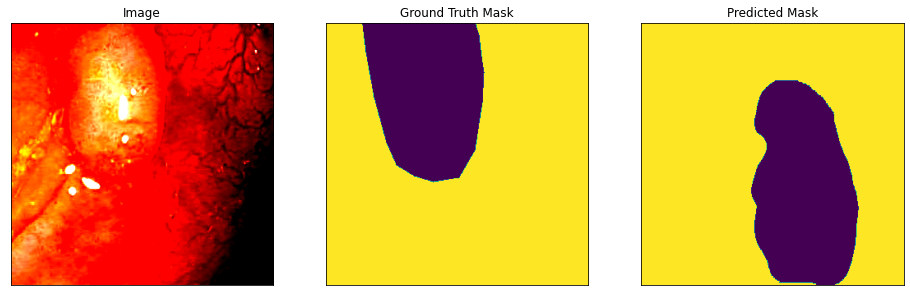

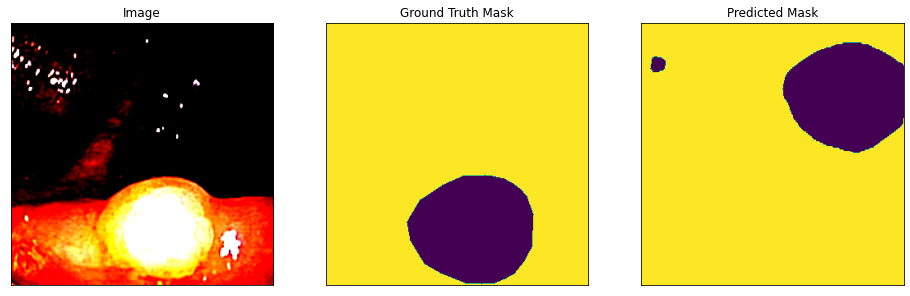

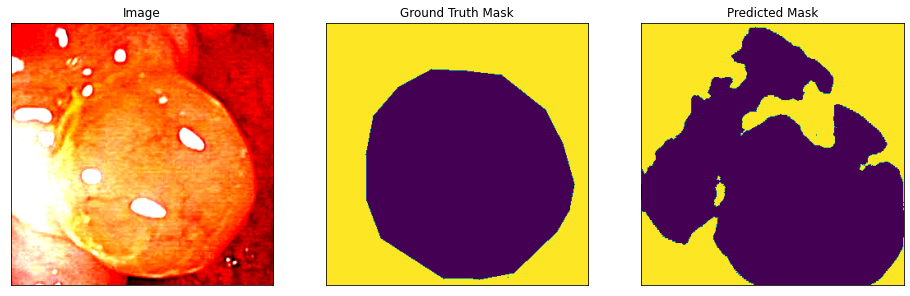

In [22]:
threshold = 0.5
break_at = 2

for i, (input, output) in enumerate(zip(
        test_dataset, runner.callbacks[1].predictions["logits"])):
    image, mask = input
    
    image_vis = image.transpose(1, 2, 0)
    gt_mask = mask[0].astype('uint8')
    pr_mask = (output[0] > threshold).astype('uint8')
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    if i >= break_at:
      break